# Libs utilizadas

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns
import statsmodels.api as sm
import scipy
from scipy.stats import boxcox
from datetime import datetime
from math import sqrt
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pyplot import figure
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from modulos.estacionaridade import *
from modulos.testes_estacionarios import *
from modulos.Credito import *
from modulos.filtros import *
from modulos.carregamento import *

# Filtrando warnings
warnings.filterwarnings("ignore")

___

# 1 - Organização dos Dados
> Filtragem da base de dados

Carregando a base bruta

In [146]:
df1 = pd.read_csv('data/desepesa_2018_2024.csv', encoding='latin1', sep=';')

In [147]:
df = pd.read_excel('data/despesa_2014_2017.xlsx')

In [148]:
df1 = df1[['ANO', 'MES', 'PODER', 'UO', 'UG', 'FONTE_MAE', 'NATUREZA3', 'VALOR_EMPENHADO']]
df = df[['ANO', 'MES', 'PODER', 'UO', 'UG', 'FONTE_MAE', 'NATUREZA3', 'VALOR_EMPENHADO']]
df = pd.concat([df, df1])

In [149]:
df.columns

Index(['ANO', 'MES', 'PODER', 'UO', 'UG', 'FONTE_MAE', 'NATUREZA3', 'VALOR_EMPENHADO'], dtype='object')

Organizando a base

Selecionando as colunas para análise

Criação de uma coluna Ano e Mês

In [150]:
df.head()

,ANO,MES,PODER,UO,UG,FONTE_MAE,NATUREZA3,VALOR_EMPENHADO
0,2014,6,EXE,25016,410016,146,344000000,1137990.00
1,2014,9,MPE,3004,30004,100,331000000,210537.96
2,2014,5,MPE,3004,30004,100,331000000,190434.86
3,2014,11,EXE,20516,510516,100,331000000,174294.75
4,2014,6,EXE,20516,510516,100,331000000,182815.82


In [151]:
df['ANO_MES'] = df['ANO'].astype(str) + '-' + df['MES'].astype(str)

#### Filtro dos dados!
Definições: 
Unidade Gestora.  
Natureza.  
Poder.  

**FIltro de maior relevância!**

In [152]:
# UO == 21018, NATURZA3 == 331000000, PODER == 'EXE'
# SEFAZ, DESPESA COM PESSOAL E PODER EXECUTIVO
# df_test = df_test[df_test['UO'] == 21018]
# df_test = df_test[df_test['NATUREZA3'] == 331000000] # Filtrando a Natureza de Pessoal de Operação
# df_test = df_test[df_test['PODER'] == 'EXE'] # Apenas o poder executivo

In [153]:
df = df.sort_values(by=['ANO', 'MES']).reset_index(drop=True)

In [154]:
# Transformando em 'Object' ANO, MES, PODER, UO, UG, FONTE_MAE, NATUREZA3.
convertendo_obj = ['ANO', 'MES', 'PODER', 'UO', 'UG', 'FONTE_MAE', 'NATUREZA3']
for column in convertendo_obj:
    df[column] = df[column].astype('object')

In [155]:
# Convertendo para Datetime ANO_MES 
df['ANO_MES'] = pd.to_datetime(df['ANO_MES'], format='%Y-%m')

> Verificação descritiva antes de AGRUPAR!

In [156]:
df['VALOR_EMPENHADO'].describe()

count    6.850470e+05
mean     1.861016e+05
std      2.469266e+06
min     -2.817000e+08
25%      3.500000e+01
50%      1.480000e+03
75%      1.350000e+04
max      3.690000e+08
Name: VALOR_EMPENHADO, dtype: float64

> Verificação de valor nulo ou ausente

In [157]:
df_valores_ruins = df[df['VALOR_EMPENHADO'] <= 0]
print(f'Quantidade de valores ruins: {df_valores_ruins.shape[0]}')
print(f'quantidade de vaores negativos: {df_valores_ruins[df_valores_ruins["VALOR_EMPENHADO"] < 0].shape[0]}')
print(f'quantidade de valores 0: {df_valores_ruins[df_valores_ruins["VALOR_EMPENHADO"] == 0].shape[0]}')

Quantidade de valores ruins: 165982
quantidade de vaores negativos: 26688
quantidade de valores 0: 139294


In [158]:
df.shape

(685047, 9)

In [159]:
quantidade_de_valor_ausente = df['VALOR_EMPENHADO'].isnull().sum().sum()
print(f'Quantidade de valores ausentes: {quantidade_de_valor_ausente}')

Quantidade de valores ausentes: 0


In [160]:
df['VALOR_EMPENHADO'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 685047 entries, 0 to 685046
Series name: VALOR_EMPENHADO
Non-Null Count   Dtype  
--------------   -----  
685047 non-null  float64
dtypes: float64(1)
memory usage: 5.2 MB


> Verificação da porcentagem de valores atribuidos com '0'.

In [161]:
# Caclular a porcentagem de valores 0 em realcao ao total
porcentagem_de_zeros = df[df['VALOR_EMPENHADO'] == 0].shape[0] / df.shape[0] * 100
print(f'Porcetagem de valores 0: {porcentagem_de_zeros:.2f}%')

Porcetagem de valores 0: 20.33%


In [162]:
df = df[df['VALOR_EMPENHADO'] > 0]

In [163]:
df.shape

(519065, 9)


> Agrupando os dados na frêquencia 'MENSAL'.

In [164]:
# Agrupando
df = df.groupby(['ANO_MES'])['VALOR_EMPENHADO'].sum().reset_index()

In [165]:
df.head()

,ANO_MES,VALOR_EMPENHADO
0,2014-01-01,1.895801e+09
1,2014-02-01,5.287013e+08
2,2014-03-01,5.196278e+08
3,2014-04-01,5.844282e+08
4,2014-05-01,5.885324e+08


In [166]:
dados = df.copy()

> ! Setembro ainda não encerrou, então foi retirado da análise!

In [167]:
dados.tail()

,ANO_MES,VALOR_EMPENHADO
124,2024-05-01,1.482428e+09
125,2024-06-01,1.527629e+09
126,2024-07-01,1.549085e+09
127,2024-08-01,1.414779e+09
128,2024-09-01,2.474858e+08


In [168]:
# Setembro não acabou, então não temos o valor oficial de setembro de 2024
dados = dados[dados['ANO_MES'] != '2024-09-01']

In [169]:
# Setando o index
dados.index = dados['ANO_MES']
dados.drop('ANO_MES', axis=1, inplace=True)

In [170]:
dados.head()

,VALOR_EMPENHADO
ANO_MES,
2014-01-01,1.895801e+09
2014-02-01,5.287013e+08
2014-03-01,5.196278e+08
2014-04-01,5.844282e+08
2014-05-01,5.885324e+08


In [171]:
dados.tail()

,VALOR_EMPENHADO
ANO_MES,
2024-04-01,1.560008e+09
2024-05-01,1.482428e+09
2024-06-01,1.527629e+09
2024-07-01,1.549085e+09
2024-08-01,1.414779e+09


> Dados está pronto para ser análisado

___

# 2 - Análise

Formatação Gŕafica - Padrão

In [172]:
# Formatação para gráficos e tabelas
plt.style.use('ggplot')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500 )
pd.set_option('display.width', 1000)

In [173]:
# Formatando os Labels
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

> Atribuindo a coluna responsável pela 'data' como index, tornando o df em uma series

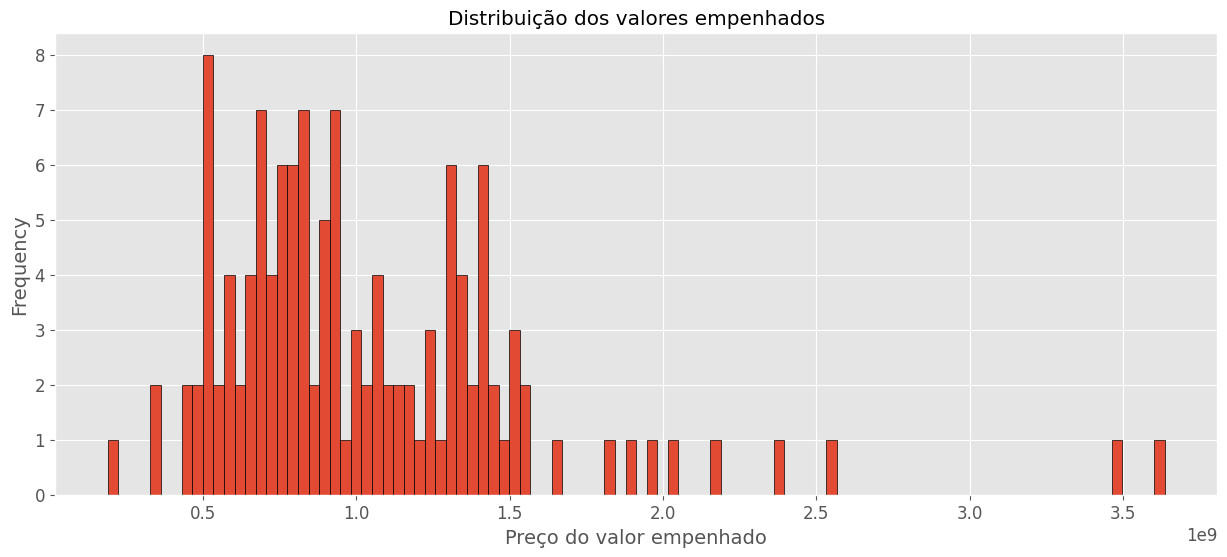

In [174]:
plt.figure(figsize=(15, 6))
dados['VALOR_EMPENHADO'].plot.hist(bins=100, grid=True, edgecolor='black').autoscale(enable=True)
plt.xlabel('Preço do valor empenhado')
plt.title('Distribuição dos valores empenhados')
plt.show()

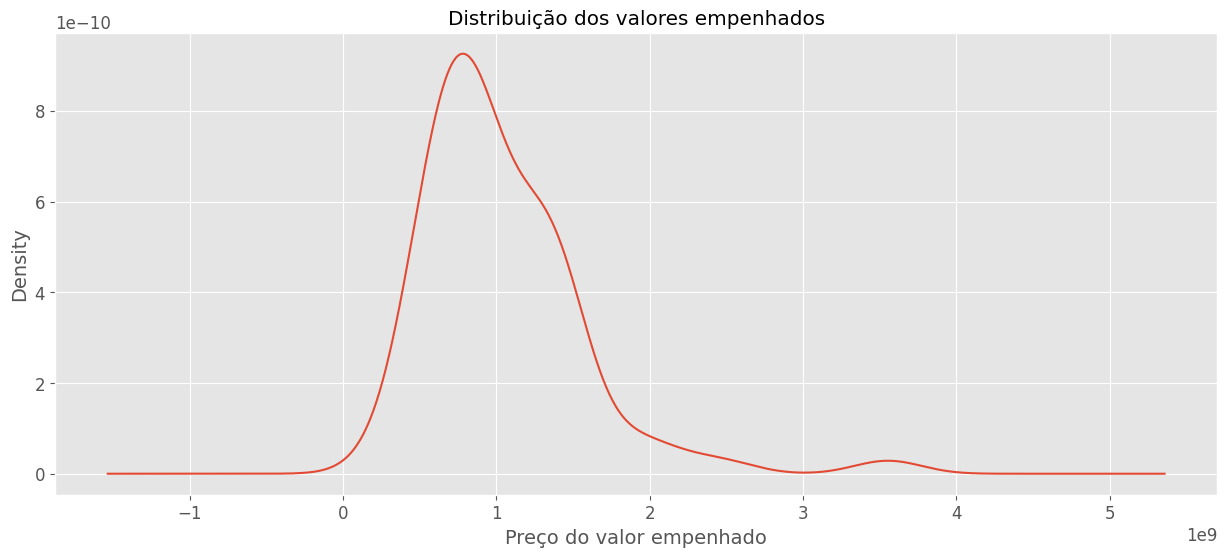

In [175]:
plt.figure(figsize=(15, 6))
dados['VALOR_EMPENHADO'].plot.kde()
plt.xlabel('Preço do valor empenhado')
plt.title('Distribuição dos valores empenhados')
plt.show()

<Figure size 1500x600 with 0 Axes>

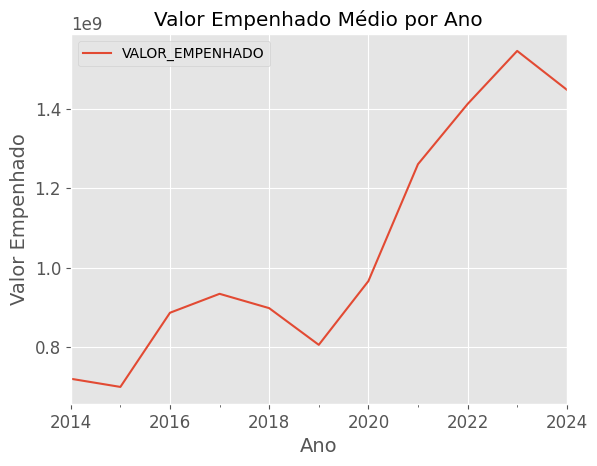

            VALOR_EMPENHADO
ANO_MES                    
2014-12-31     7.206163e+08
2015-12-31     7.000657e+08
2016-12-31     8.865330e+08
2017-12-31     9.341275e+08
2018-12-31     8.980974e+08
2019-12-31     8.058688e+08
2020-12-31     9.660434e+08
2021-12-31     1.260023e+09
2022-12-31     1.411240e+09
2023-12-31     1.544757e+09
2024-12-31     1.447297e+09


In [176]:
# valor medio do valor empnheado por ano, plo
plt.figure(figsize=(15, 6))
dados.resample('Y').mean().plot(grid=True)
plt.xlabel('Ano')
plt.ylabel('Valor Empenhado')
plt.title('Valor Empenhado Médio por Ano')
plt.show()
media_ano = dados.resample('Y').mean()
print(media_ano)

In [177]:
dados.shape

(128, 1)

In [178]:
dados_treino = dados.iloc[:-12]
dados_treino

,VALOR_EMPENHADO
ANO_MES,
2014-01-01,1.895801e+09
2014-02-01,5.287013e+08
2014-03-01,5.196278e+08
2014-04-01,5.844282e+08
2014-05-01,5.885324e+08
...,...
2023-04-01,1.334346e+09
2023-05-01,1.408602e+09
2023-06-01,1.407576e+09


In [179]:
dados_teste = dados.iloc[-12:]
dados_teste

,VALOR_EMPENHADO
ANO_MES,
2023-09-01,2.017830e+09
2023-10-01,1.038205e+09
2023-11-01,1.365538e+09
2023-12-01,3.473475e+09
2024-01-01,1.147500e+09
2024-02-01,1.369704e+09
2024-03-01,1.527246e+09
2024-04-01,1.560008e+09
2024-05-01,1.482428e+09


In [180]:
dados_teste

,VALOR_EMPENHADO
ANO_MES,
2023-09-01,2.017830e+09
2023-10-01,1.038205e+09
2023-11-01,1.365538e+09
2023-12-01,3.473475e+09
2024-01-01,1.147500e+09
2024-02-01,1.369704e+09
2024-03-01,1.527246e+09
2024-04-01,1.560008e+09
2024-05-01,1.482428e+09


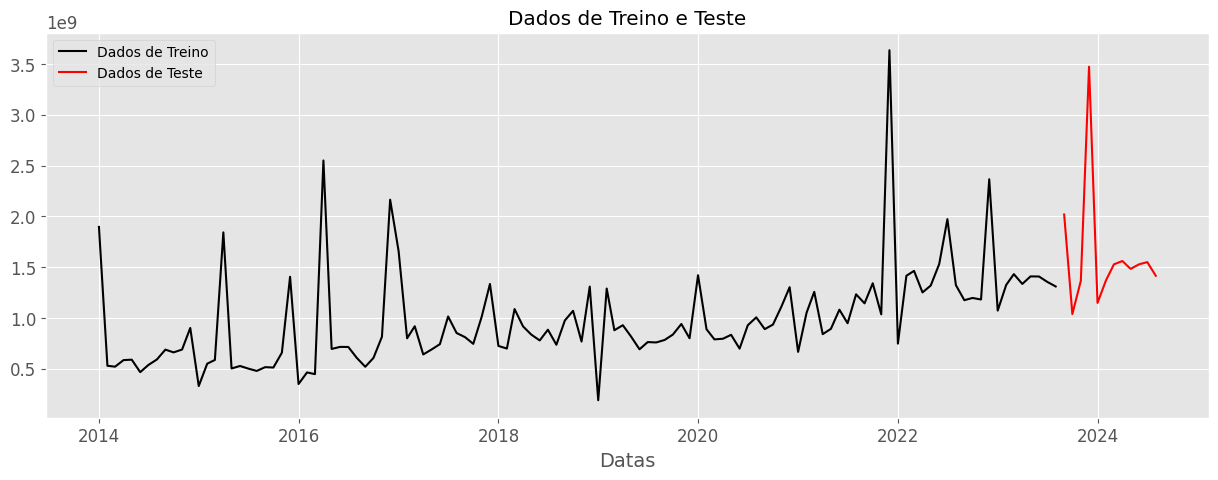

In [181]:
# Supondo que dados_treino e dados_teste são DataFrames do Pandas
plt.figure(figsize=(15, 5))
plt.plot(dados_treino, color='black', label='Dados de Treino')
plt.plot(dados_teste, color='red', label='Dados de Teste')
plt.title('Dados de Treino e Teste')
plt.xlabel('Datas')
plt.legend()
plt.show()

___

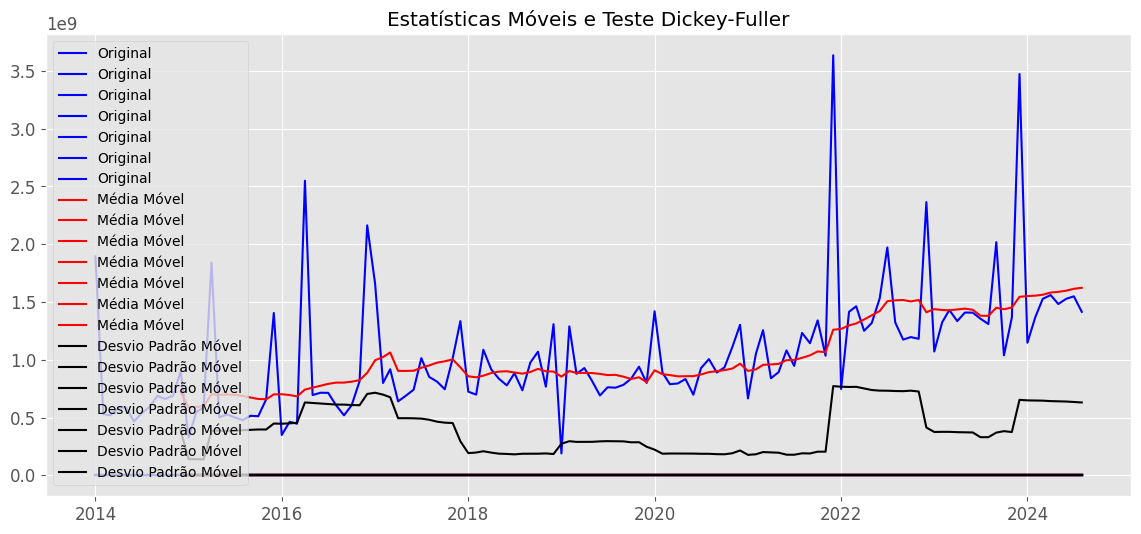


Resultado do Teste Dickey-Fuller:


ValueError: x is required to have ndim 1 but has ndim 2

In [282]:
dsa_testa_estacionaridade(dados)

Algoritmo de Suavização Simples

In [183]:
import pandas as pd
import datetime
from pandas import Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [184]:
dados_treino.index.freq='MS'

In [185]:
model1 = ExponentialSmoothing(dados_treino).fit(smoothing_level=0.5, optimized=True)
modelo1 = model1.forecast(len(dados_teste))
modelo1

2023-09-01    1.343044e+09
2023-10-01    1.343044e+09
2023-11-01    1.343044e+09
2023-12-01    1.343044e+09
2024-01-01    1.343044e+09
2024-02-01    1.343044e+09
2024-03-01    1.343044e+09
2024-04-01    1.343044e+09
2024-05-01    1.343044e+09
2024-06-01    1.343044e+09
2024-07-01    1.343044e+09
2024-08-01    1.343044e+09
Freq: MS, dtype: float64

Suavização Holt

In [186]:
model2 = Holt(dados_treino).fit(smoothing_level=0.5)
modelo2 = model2.forecast(len(dados_teste))
modelo2

2023-09-01    1.315655e+09
2023-10-01    1.297214e+09
2023-11-01    1.278773e+09
2023-12-01    1.260332e+09
2024-01-01    1.241891e+09
2024-02-01    1.223450e+09
2024-03-01    1.205009e+09
2024-04-01    1.186568e+09
2024-05-01    1.168127e+09
2024-06-01    1.149687e+09
2024-07-01    1.131246e+09
2024-08-01    1.112805e+09
Freq: MS, dtype: float64

Algoritmo de Suavização Holt-Winter

In [187]:
model3 = ExponentialSmoothing(dados_treino, trend='add', seasonal='add').fit()
modelo3 = model3.forecast(len(dados_teste))
modelo3

2023-09-01    1.311815e+09
2023-10-01    1.344309e+09
2023-11-01    1.413219e+09
2023-12-01    2.203480e+09
2024-01-01    1.373298e+09
2024-02-01    1.399959e+09
2024-03-01    1.470822e+09
2024-04-01    1.788645e+09
2024-05-01    1.393166e+09
2024-06-01    1.410107e+09
2024-07-01    1.498423e+09
2024-08-01    1.427539e+09
Freq: MS, dtype: float64

Algoritmo de Suavização Holt-Winter - Multiplicativo

In [188]:
model4 = ExponentialSmoothing(dados_treino, trend='add', seasonal='mul').fit()
modelo4 = model4.forecast(len(dados_teste))
modelo4

2023-09-01    1.230666e+09
2023-10-01    1.298632e+09
2023-11-01    1.311843e+09
2023-12-01    2.554617e+09
2024-01-01    1.195103e+09
2024-02-01    1.394914e+09
2024-03-01    1.465432e+09
2024-04-01    1.590520e+09
2024-05-01    1.327258e+09
2024-06-01    1.365835e+09
2024-07-01    1.497672e+09
2024-08-01    1.362459e+09
Freq: MS, dtype: float64

Algoritimo de Suavização de Pegels

In [189]:
model5 = ExponentialSmoothing(dados_treino, trend='mul', seasonal='add').fit()
modelo5 = model5.forecast(len(dados_teste))
modelo5

2023-09-01    1.403105e+09
2023-10-01    1.441807e+09
2023-11-01    1.516164e+09
2023-12-01    2.314531e+09
2024-01-01    1.487718e+09
2024-02-01    1.524871e+09
2024-03-01    1.600426e+09
2024-04-01    1.924730e+09
2024-05-01    1.547016e+09
2024-06-01    1.570656e+09
2024-07-01    1.665423e+09
2024-08-01    1.610259e+09
Freq: MS, dtype: float64

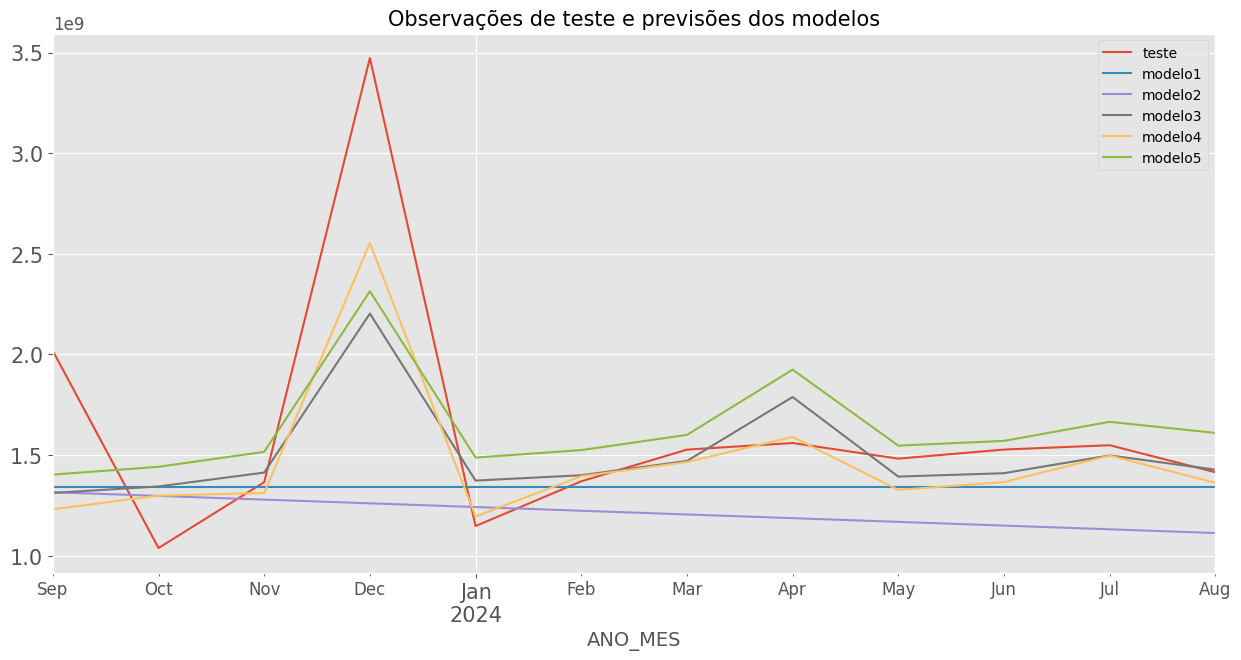

In [190]:
dados_teste.plot(figsize=(15,7))
modelo1.plot() #Algoritmo de suavização simples
modelo2.plot() #Algoritmo de suavização Holt
modelo3.plot() #Algoritmo de suavização Holt-Winter aditivo
modelo4.plot() #Algortimo de suavização Holt-Winter multiplicativo
modelo5.plot() #Algortimo de suavização Pegels
plt.title("Observações de teste e previsões dos modelos", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
lista=['teste','modelo1','modelo2','modelo3','modelo4','modelo5']
plt.legend(lista)
plt.show()

In [191]:
print('*************Métricas do Algoritmo de Suavização Simples*************')
print(' '*254)
print('Erro médio absoluto do Algoritmo de Suavização Simples :',
      round(mean_absolute_error(dados_teste,modelo1),3))
print('Raiz do erro médio quadrado do Algoritmo de Suavização Simples :',
      round(mean_squared_error(dados_teste,modelo1)**0.5,3))
print(' '*254)
print('*************Métricas do Algoritmo de Suavização de Holt*************')
print(' '*254)
print('Erro médio absoluto do Algoritmo de Suavização Holt:',
      round(mean_absolute_error(dados_teste,modelo2),3))
print('Raiz do erro médio quadrado do Algoritmo de Suavização',
      round(mean_squared_error(dados_teste,modelo2)**0.5,3))
print(' '*254)
print('*************Métricas do Algoritmo de Suavização de Holt-Winters aditivo*************')
print(' '*254)
print('Erro médio absoluto do Algoritmo de Suavização Holt-Winters aditivo :',
      round(mean_absolute_error(dados_teste,modelo3),3))
print('Raiz do erro médio quadrado do Algoritmo de Suavização Holt-Winters aditivo :',
      round(mean_squared_error(dados_teste,modelo3)**0.5,3))
print(' '*254)
print('*************Métricas do Algoritmo de Suavização de Holt-Winters multiplicativo*************')
print(' '*254)
print('Erro médio absoluto do Algoritmo de Suavização Holt-Winters multiplicativo :',
      round(mean_absolute_error(dados_teste,modelo4),3))
print('Raiz do erro médio quadrado do Algoritmo de Suavização Holt-Winters multiplicativo :',
      round(mean_squared_error(dados_teste,modelo4)**0.5,3))
print(' '*254)
print('*************Métricas do Algoritmo de Suavização de Pegels aditivo *************')
print(' '*254)
print('Erro médio absoluto do Algoritmo de Suavização Pegels aditivo :',
      round(mean_absolute_error(dados_teste,modelo5),3))
print('Raiz do erro médio quadrado do Algoritmo de Suavização Pegels aditivo :',
      round(mean_squared_error(dados_teste,modelo5)**0.5,3))

*************Métricas do Algoritmo de Suavização Simples*************
                                                                                                                                                                                                                                                              
Erro médio absoluto do Algoritmo de Suavização Simples : 363138728.607
Raiz do erro médio quadrado do Algoritmo de Suavização Simples : 665116172.343
                                                                                                                                                                                                                                                              
*************Métricas do Algoritmo de Suavização de Holt*************
                                                                                                                                                                                                        

Aplicando forma

In [192]:
def previsao_hw(nome , df_completo, inicial_treino, limite_treino, periodos_season, numero_previsao):

  '''
  A função a seguir roda todos os 4 modelos (add e mult na sazonalidade e tendência) para o dataframe fornecido de acordo com os parâmetros abaixo:

  Argumentos:

  1. nome (str): Nome da previsão
  2. df_completo (var): Dataframe com todos os dados
  3. inicial_treino (str ou datatime): Data inicial dos dados de treino no formato YYYY-MM-DD
  4. limite_treino (str ou datatime): Data limite dos dados de treino no formato YYYY-MM-DD
  5. periodos_season (int): Períodos referentes a sazonalidade
  6. numero_previsao (int): Número de observações a serem previstas

  Retorno:

  Lista com os nomes das variáveis criadas para a previsão de cada modelo específico e as variáveis dos modelos individualmente contendo os dados concatenados (treino e previsto).
  '''

  # Ajustando a base de treino e real
  df_treino = df_completo.loc[(df_completo.index >= inicial_treino) & (df_completo.index <= limite_treino)]
  df_real = df_completo.loc[(df_completo.index > limite_treino)]
  df_prev_1 = pd.DataFrame(df_treino) # transformando em df caso apenas uma serie seja retornada

  # Realizando a previsão

  # Para realizar previsão de diferentes modelos dos que já estão listados aqui adicione mais itens no dict
  # Ordem: Tendência, Sazonalidade, Damped (bool)

  modelos_dic = {'prev_aa': ['add', 'add', False],
                 'prev_am': ['add', 'mul', False],
                 'prev_mm': ['mul', 'mul', False],
                 'prev_ma': ['mul', 'add', False],
                 'prev_aa_damp': ['add', 'add', True],
                 'prev_am_damp': ['add', 'mul', True],
                 'prev_mm_damp': ['mul', 'mul', True],
                 'prev_ma_damp': ['mul', 'add', True]
                 }

  for i in df_prev_1.columns:

    for nome_df, modelos in modelos_dic.items():

      modelo = ExponentialSmoothing(
                                df_prev_1[i],
                                seasonal_periods=periodos_season,
                                trend=modelos[0],
                                seasonal=modelos[1],
                                damped_trend=modelos[2]
                                ).fit(optimized=True)
      globals()[nome + "_mod_" + nome_df] = modelo
      previsao = modelo.forecast(numero_previsao)
      df_prev_2 = pd.concat([df_treino, previsao], axis=0)
      df_prev_2 = pd.DataFrame(df_prev_2, columns=df_prev_1.columns)
      globals()[nome + "_df_" + nome_df] = df_prev_2

  global lista_modelos
  global lista_df_prev
  lista_modelos = []
  lista_df_prev = []
  for i in modelos_dic.keys():
      lista_modelos.append(nome + "_mod_" + i)
      lista_df_prev.append(nome + "_df_" + i)

  def nomes(modelos_dic):
    print('Variaveis criadas: \n')
    print('Modelos: \n')
    print("lista_modelos \n")
    for i in modelos_dic.keys():
      print(nome + "_mod_" + i)
    print("\nDataframes com previsão: \n")
    print("lista_df_prev \n")
    for i in modelos_dic.keys():
      print(nome + "_df_" + i)

  return nomes(modelos_dic)

In [193]:
# executando para os dados de treino
previsao_hw('dados', dados, '2018-01-01', '2023-09-01', 12, 24)

Variaveis criadas: 

Modelos: 

lista_modelos 

dados_mod_prev_aa
dados_mod_prev_am
dados_mod_prev_mm
dados_mod_prev_ma
dados_mod_prev_aa_damp
dados_mod_prev_am_damp
dados_mod_prev_mm_damp
dados_mod_prev_ma_damp

Dataframes com previsão: 

lista_df_prev 

dados_df_prev_aa
dados_df_prev_am
dados_df_prev_mm
dados_df_prev_ma
dados_df_prev_aa_damp
dados_df_prev_am_damp
dados_df_prev_mm_damp
dados_df_prev_ma_damp


In [194]:
dados_df_prev_ma_damp

,VALOR_EMPENHADO
2018-01-01,7.235728e+08
2018-02-01,6.980889e+08
2018-03-01,1.086823e+09
2018-04-01,9.164570e+08
2018-05-01,8.358283e+08
...,...
2025-05-01,NaN
2025-06-01,NaN
2025-07-01,NaN
2025-08-01,NaN


# 3 - Estatísticas Móveis

*Nesse teste foi definido uma janela de 12 Meses!*

In [195]:
# Função para testar a estacionaridade
def dsa_testa_estacionaridade(serie, window = 12, title = 'Estatísticas Móveis e Teste Dickey-Fuller'):
    """
    Função para testar a estacionaridade de uma série temporal.
    
    Parâmetros:
    - serie: pandas.Series. Série temporal a ser testada.
    - window: int. Janela para cálculo das estatísticas móveis.
    - title: str. Título para os gráficos.
    """
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = window).mean()
    rolstd = serie.rolling(window = window).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (14, 6))
    plt.plot(serie, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    plt.plot(rolstd, color = 'black', label = 'Desvio Padrão Móvel')
    plt.legend(loc = 'best')
    plt.title(title)
    plt.show(block = False)
    
    # Teste Dickey-Fuller
    print('\nResultado do Teste Dickey-Fuller:')
    dfteste = adfuller(serie, autolag = 'AIC')
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste', 
                                               'Valor-p', 
                                               'Número de Lags Consideradas', 
                                               'Número de Observações Usadas'])
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)' % key] = value
        
    print(dfsaida)
    
    # Conclusão baseada no valor-p
    if dfsaida['Valor-p'] > 0.05:
        print('\nConclusão:\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente não é estacionária.')
    else:
        print('\nConclusão:\nO valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente é estacionária.')

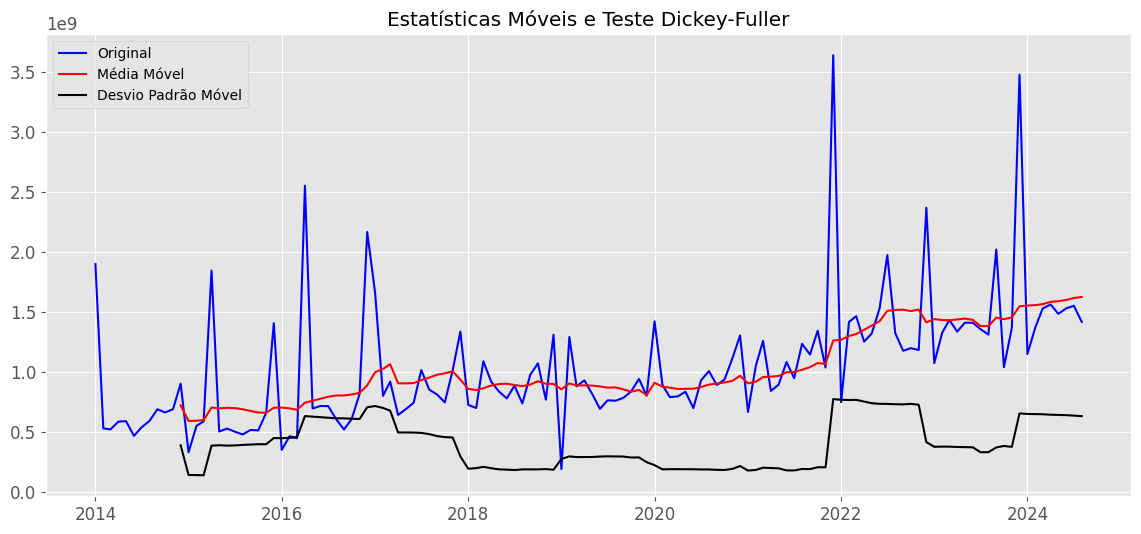


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -0.187659
Valor-p                           0.939977
Número de Lags Consideradas      11.000000
Número de Observações Usadas    116.000000
Valor Crítico (1%)               -3.488022
Valor Crítico (5%)               -2.886797
Valor Crítico (10%)              -2.580241
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [196]:
# Testa a estacionaridade
teste_dsa = dsa_testa_estacionaridade(dados)

Função em execução.  
> LEMBRETE: Ao executar o teste, é removido 12 meses da amostra! (Configuavel na função "dsa_testa_estacionaridade)

___

# 4 - Transformação em Estacionária

> Métodos para tornar a série estacionária:
- Log  
- Raiz Quadrada
- Box-Cox
- Suavização através da Média Móvel Simples (MMS)
- Suavização através da Média Móvel Ponderada Exponencial (MMPE)
- Diferenciação (existe vários tipos)

> Para esse notebook, foi aplicado apenas transformação de Log. 


Quando a média e o desvio padrão não são pŕoximos, provavelmente a série é não estacionária.

In [197]:
# Média da série
print('Média:', dados['VALOR_EMPENHADO'].mean())
# Desvio Padrão da Série
print(f'Desvio Padrão:', dados['VALOR_EMPENHADO'].std())

Média: 1039897202.9461718
Desvio Padrão: 530061569.1888013


### Transformação de LOG
> Aplicando a transformação de LOG

In [198]:
# Vamos aplicar uma transformação de log usando np.log() e gravamos o resultado em uma nova coluna do nosso dataset
dados['VALOR_EMPENHADO_log'] = np.log(dados['VALOR_EMPENHADO'])
dados.head()

,VALOR_EMPENHADO,VALOR_EMPENHADO_log
ANO_MES,,
2014-01-01,1.895801e+09,21.362907
2014-02-01,5.287013e+08,20.085934
2014-03-01,5.196278e+08,20.068623
2014-04-01,5.844282e+08,20.186145
2014-05-01,5.885324e+08,20.193142


> Checando estacionáriadade após transformação

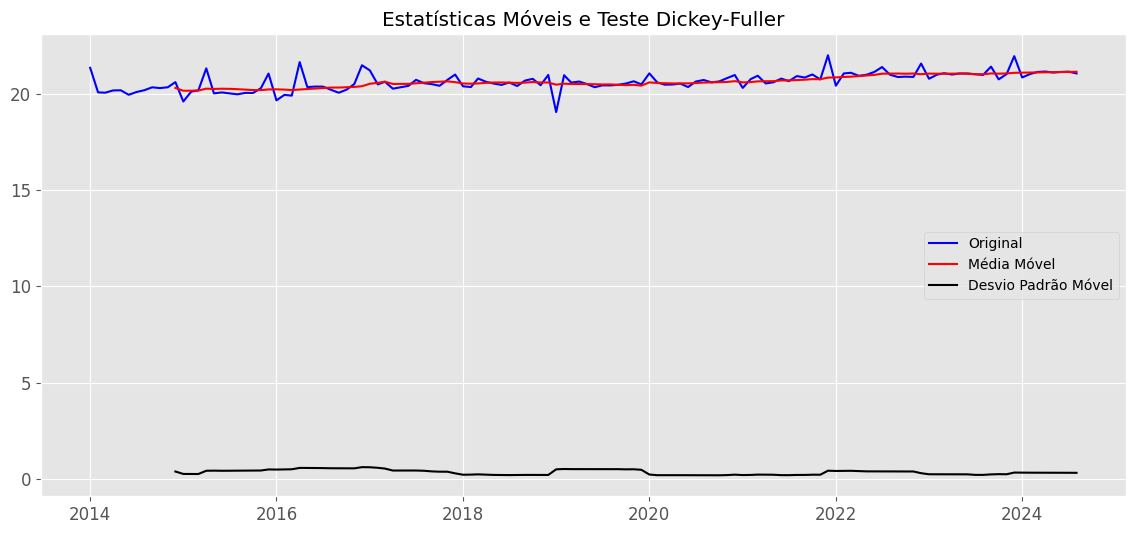


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -0.299637
Valor-p                           0.925556
Número de Lags Consideradas      11.000000
Número de Observações Usadas    116.000000
Valor Crítico (1%)               -3.488022
Valor Crítico (5%)               -2.886797
Valor Crítico (10%)              -2.580241
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [199]:
# Testando Estacionaridade
dsa_testa_estacionaridade(dados['VALOR_EMPENHADO_log'])

Objetivo alcançado!

___

# 5 - Modelagem
> Existem vários modelos de previsão de série temporal:
- Forecasting - Método Naive (Método fraco)

Criação de um dataframe para prever valores futuros
> Esse dataframe contém 200 meses para frente, iniciando em 2024 - 09

Será usado futuramente

In [200]:
novos_meses = pd.date_range(start=dados.index[-1] + pd.DateOffset(months=1), periods=200, freq='MS')
df_novos_meses = pd.DataFrame({'VALOR_EMPENHADO': [0]*200}, index=novos_meses)
dados_previsao_futura = pd.concat([dados, df_novos_meses])
dados_previsao_futura = dados_previsao_futura[dados_previsao_futura['VALOR_EMPENHADO'] == 0]
dados_previsao_futura['data'] = dados_previsao_futura.index

Definição de Target / Valor alvo.
> Nesse caso, o valor alvo é 'VALOR_EMPENHADO', porém, será usado a sua transformação log realizada anteriormente

In [201]:
target = dados['VALOR_EMPENHADO_log']

#### Fatiando os dados, e escolhendo os dados treino e dados testes

Lembre-se do tamanho dos dados:

In [202]:
dados.shape

(128, 2)

In [203]:
df_treino = dados.iloc[0:50]
df_valid = dados.iloc[50:]

In [204]:
df_treino.head()

,VALOR_EMPENHADO,VALOR_EMPENHADO_log
ANO_MES,,
2014-01-01,1.895801e+09,21.362907
2014-02-01,5.287013e+08,20.085934
2014-03-01,5.196278e+08,20.068623
2014-04-01,5.844282e+08,20.186145
2014-05-01,5.885324e+08,20.193142


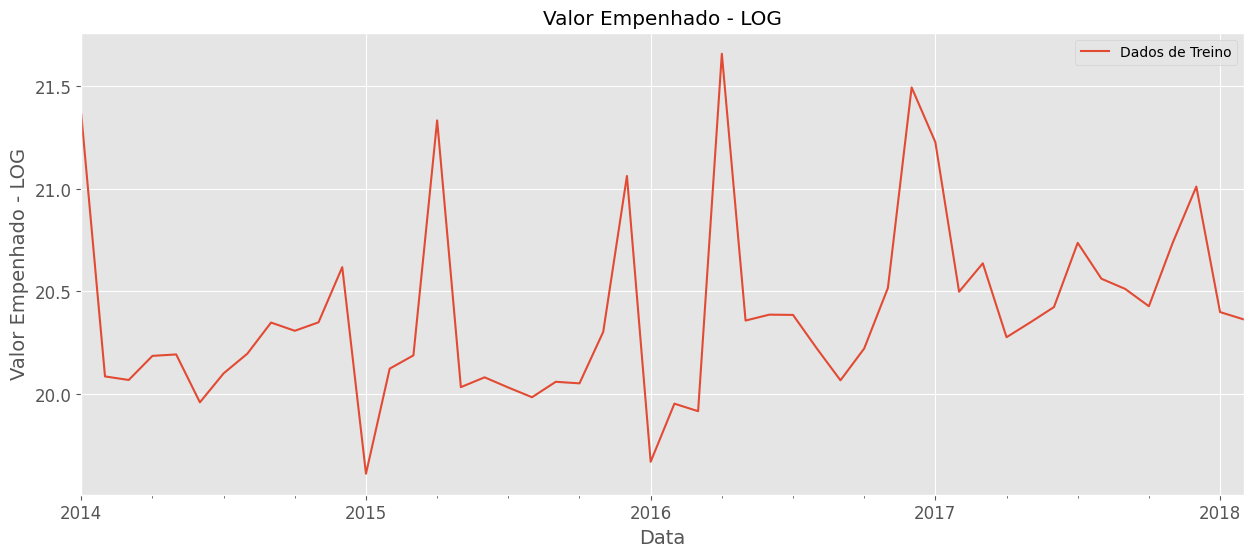

In [205]:
# Plot
figure(figsize = (15, 6))
df_treino['VALOR_EMPENHADO_log'].plot(title = 'Valor Empenhado - LOG', 
                               fontsize = 12, 
                               label = 'Dados de Treino') 
plt.xlabel("Data") 
plt.ylabel("Valor Empenhado - LOG") 
plt.legend(loc = 'best') 
plt.show()

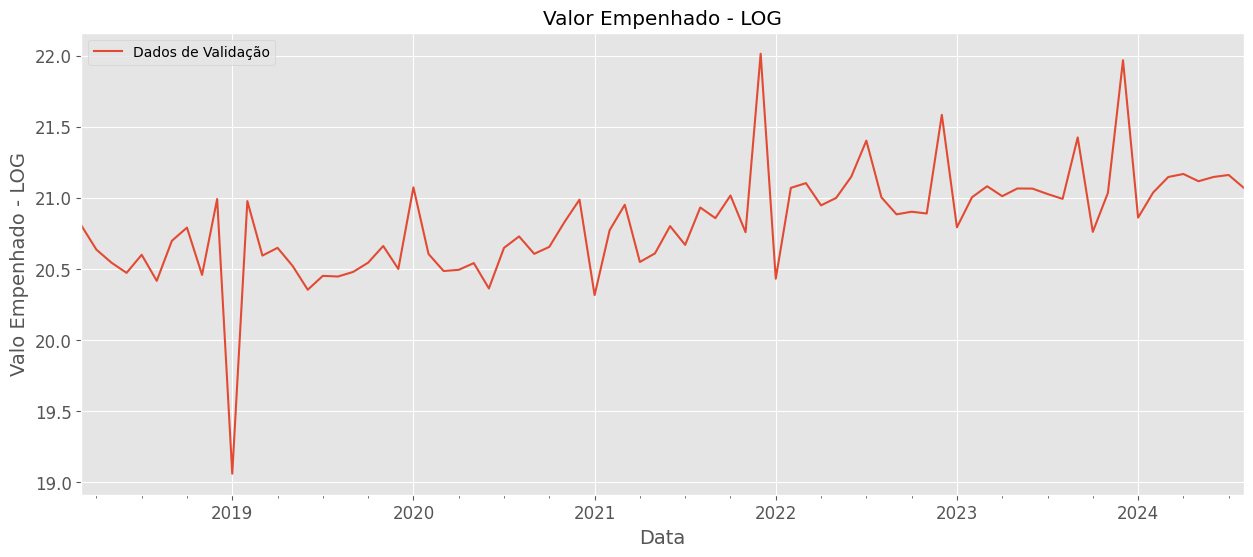

In [206]:
# Plot
figure(figsize = (15, 6))
df_valid['VALOR_EMPENHADO_log'].plot(title = 'Valor Empenhado - LOG', 
                              fontsize = 12, 
                              label = 'Dados de Validação') 
plt.xlabel("Data") 
plt.ylabel("Valo Empenhado - LOG") 
plt.legend(loc = 'best') 
plt.show()

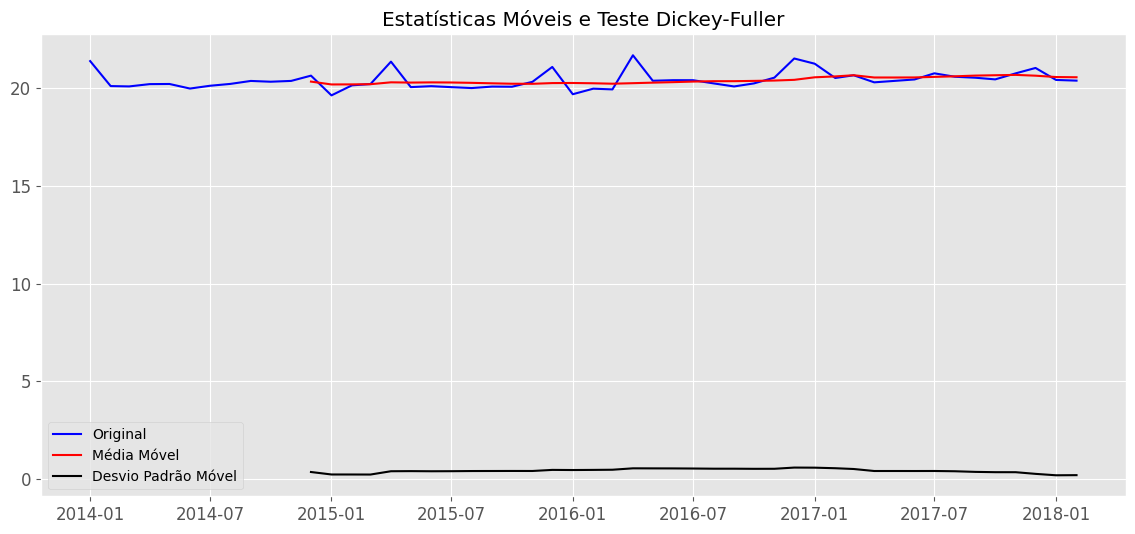


Resultado do Teste Dickey-Fuller:
Estatística do Teste           -6.326345e+00
Valor-p                         2.979921e-08
Número de Lags Consideradas     0.000000e+00
Número de Observações Usadas    4.900000e+01
Valor Crítico (1%)             -3.571472e+00
Valor Crítico (5%)             -2.922629e+00
Valor Crítico (10%)            -2.599336e+00
dtype: float64

Conclusão:
O valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [207]:
dsa_testa_estacionaridade(df_treino['VALOR_EMPENHADO_log'])

# Forecasting

> Criando um Array com os valores da variavel Target em treino

In [208]:
# Criamos um array com os valores da variável target em treino
array_VALOR_EMPENHADO_log_treino = np.asarray(df_treino['VALOR_EMPENHADO_log'])

In [209]:
type(array_VALOR_EMPENHADO_log_treino)

numpy.ndarray

In [210]:
array_VALOR_EMPENHADO_log_treino.shape

(50,)

___

# Método Naive

In [211]:
# Cria uma cópia dos dados de validação para usar na comparação dos dados reais com as previsões
df_valid_cp = df_valid.copy()

In [212]:
len(array_VALOR_EMPENHADO_log_treino)

50

In [213]:
# Previsão. Sim, isso é o Método Naive!
df_valid_cp['previsao_naive'] = array_VALOR_EMPENHADO_log_treino[len(array_VALOR_EMPENHADO_log_treino) - 1] 

In [214]:
df_valid_cp[['VALOR_EMPENHADO_log', 'previsao_naive']].head()

,VALOR_EMPENHADO_log,previsao_naive
ANO_MES,,
2018-03-01,20.806524,20.363857
2018-04-01,20.636026,20.363857
2018-05-01,20.543934,20.363857
2018-06-01,20.472254,20.363857
2018-07-01,20.599513,20.363857


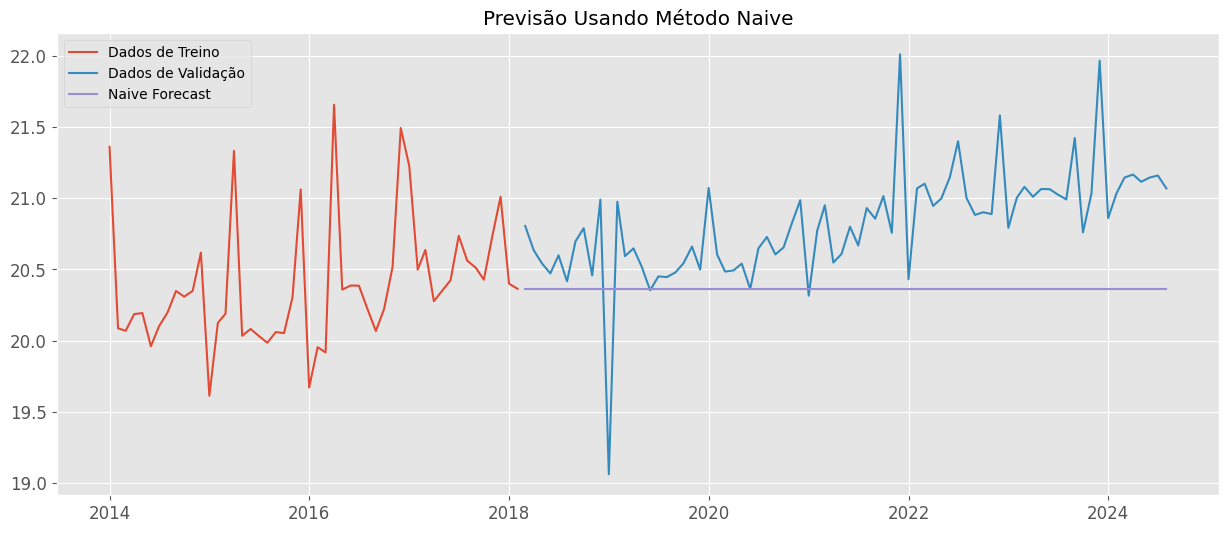

In [215]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Método Naive") 
plt.plot(df_treino.index, df_treino['VALOR_EMPENHADO_log'], label = 'Dados de Treino') 
plt.plot(df_valid.index, df_valid['VALOR_EMPENHADO_log'], label = 'Dados de Validação') 
plt.plot(df_valid_cp.index, df_valid_cp['previsao_naive'], label = 'Naive Forecast') 
plt.legend(loc = 'best') 
plt.show()

In [216]:
# Define valor real e valor previsto
y_true = df_valid_cp['VALOR_EMPENHADO_log']
y_pred = df_valid_cp['previsao_naive']

In [217]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.5989566953032103


RMSE é a taxa de erro e quanto menor, melhor!

# Exponenial Smoothing

### Ideal quando a série não apresenta tendência e/ou sazionalidade

Exponential Smoothing é uma técnica de modelagem de séries temporais que utiliza uma média móvel ponderada para prever valores futuros de uma série temporal. Cada ponto de dado é atribuído com um peso exponencial decrescente, com os pontos mais recentes recebendo mais peso e os pontos mais antigos recebendo menos peso. O resultado é uma previsão suavizada que leva em consideração tanto a tendência geral quanto a sazonalidade da série temporal.

In [218]:
# Versão 1 do modelo - Simple Exponential Smoothing 
modelo_v1 = SimpleExpSmoothing(array_VALOR_EMPENHADO_log_treino).fit(smoothing_level = 0.2, optimized = True)

In [219]:
# Previsões com o Modelo
df_valid['previsoes_v1'] = modelo_v1.forecast(len(df_valid)) 

In [220]:
# Colocamos lado a lado, valor real e valor "previsto"
df_valid[['VALOR_EMPENHADO_log', 'previsoes_v1']].head()

,VALOR_EMPENHADO_log,previsoes_v1
ANO_MES,,
2018-03-01,20.806524,20.556451
2018-04-01,20.636026,20.556451
2018-05-01,20.543934,20.556451
2018-06-01,20.472254,20.556451
2018-07-01,20.599513,20.556451


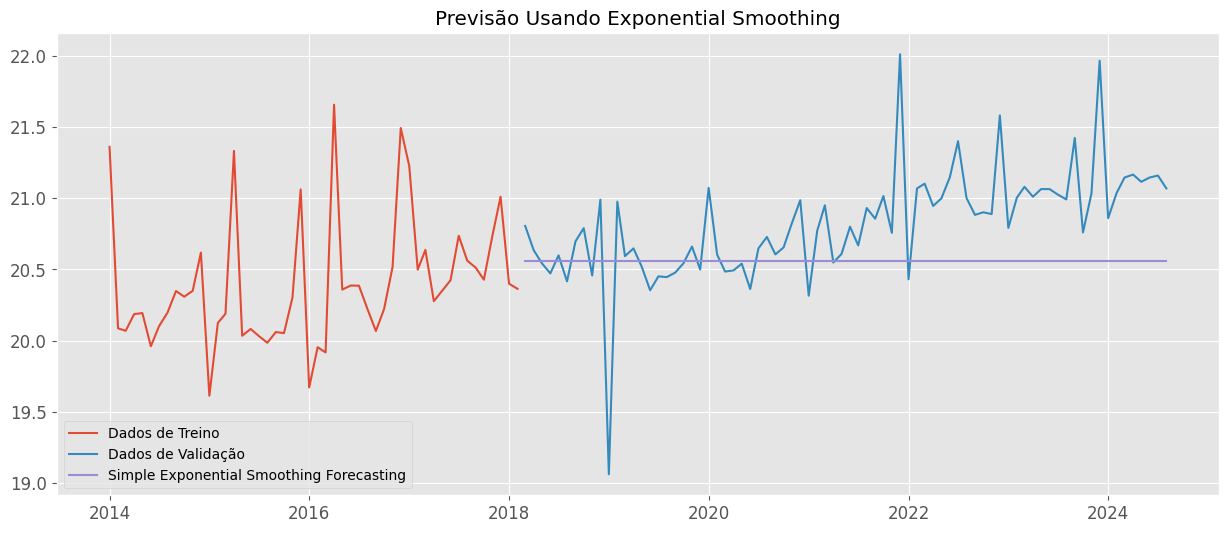

In [221]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(df_treino['VALOR_EMPENHADO_log'], label = 'Dados de Treino')
plt.plot(df_valid['VALOR_EMPENHADO_log'], label = 'Dados de Validação')
plt.plot(df_valid['previsoes_v1'], label = 'Simple Exponential Smoothing Forecasting') 
plt.legend(loc = 'best') 
plt.show()

In [222]:
# Define valor real e valor previsto
y_true = df_valid['VALOR_EMPENHADO_log']
y_pred = df_valid.previsoes_v1

In [223]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.467861034480535


___

# Double Exponential Smoothing -> Ideal com tendência
> Ao usar o hiperparâmetro trend, definimos o método Double Exponential Smoothing.
# Triple Exponential Smoothing -> Ideal com Sazionalidade
> Ao usar o hiperparâmetro seasonal, definimos o método Triple Exponential Smoothing.


In [224]:
# Versão 2 do modelo - Double Exponential Smoothing 
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

# Observe que estamos usando a função ExponentialSmoothing().
# Ao usar o hiperparâmetro trend, definimos o método Double Exponential Smoothing.
# Ao usar o hiperparâmetro seasonal, definimos o método Triple Exponential Smoothing.

# Vamos usar o Double. Como não temos sazonalidade na série, não faz muito sentido usar o Triple.
# Escolhi a série aditiva
modelo_v2 = ExponentialSmoothing(np.asarray(df_treino['VALOR_EMPENHADO_log']), 
                                 trend = 'additive').fit(smoothing_level = 0.9, 
                                                         optimized = True) 

In [225]:
# Previsões com o Modelo
df_valid.loc[:,'previsoes_v2'] = modelo_v2.forecast(len(df_valid))

In [226]:
# Colocamos lado a lado, valor real e valor "previsto"
df_valid[['VALOR_EMPENHADO_log', 'previsoes_v1', 'previsoes_v2']].head()

,VALOR_EMPENHADO_log,previsoes_v1,previsoes_v2
ANO_MES,,,
2018-03-01,20.806524,20.556451,20.353622
2018-04-01,20.636026,20.556451,20.335952
2018-05-01,20.543934,20.556451,20.318282
2018-06-01,20.472254,20.556451,20.300613
2018-07-01,20.599513,20.556451,20.282943


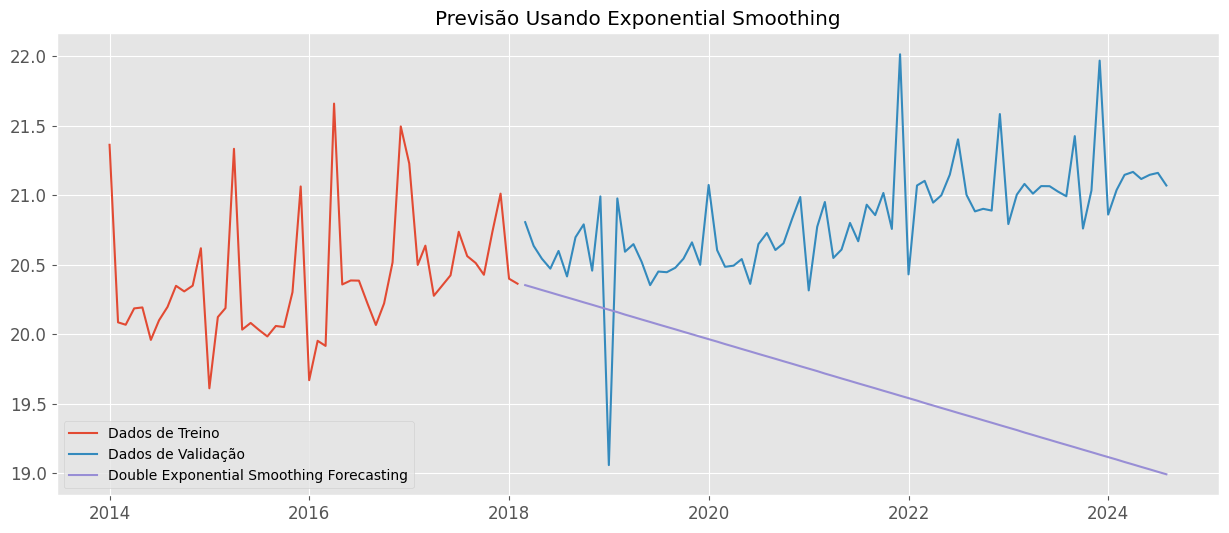

In [227]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(df_treino['VALOR_EMPENHADO_log'], label = 'Dados de Treino')
plt.plot(df_valid['VALOR_EMPENHADO_log'], label = 'Dados de Validação')
plt.plot(df_valid['previsoes_v2'], label = 'Double Exponential Smoothing Forecasting') 
plt.legend(loc = 'best') 
plt.show()

In [228]:
# Define valor real e valor previsto
y_true = df_valid['VALOR_EMPENHADO_log']
y_pred = df_valid.previsoes_v2

In [229]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

1.3471340183635445


#### Resultados acima insatisfatórios, pode indicar que métodos de Exponential Smoothing não sejam adequados para à série selecionada.

Ganhos muitos baixos, o erro do modelo foi pouco diminuido

___

### Ainda com modelos lineares, porém com outra familia
1 - Naive  
2 - Suavização Exponensial (simples, duplo e triple)  
3 - Modelos lineares da familia ARIMA


**Podemos converter o problema de série temporal, em um problema de machine learning**

# Familia Linear

Em Estatística e Econometria, e em particular na análise de séries temporais, um modelo de média móvel integrada auto-regressiva (ARIMA) é uma generalização de um modelo de média móvel auto-regressiva (ARMA). 

Ambos os modelos são ajustados a dados de séries temporais para melhor entender os dados ou para prever pontos futuros na série (previsão). Os modelos ARIMA são aplicados em alguns casos em que os dados mostram evidências de não estacionariedade, onde uma etapa inicial de diferenciação (correspondente à parte "integrada" do modelo) pode ser aplicada uma ou mais vezes para eliminar a não estacionariedade. 

A parte AR do ARIMA indica que a variável de interesse em evolução é regredida com seus próprios valores defasados (isto é, anteriores). A parte MA indica que o erro de regressão é na verdade uma combinação linear de termos de erro cujos valores ocorreram contemporaneamente e em vários momentos no passado. O I (para "integrado") indica que os valores dos dados foram substituídos pela diferença entre seus valores e os valores anteriores (e esse processo de diferenciação pode ter sido executado mais de uma vez). O objetivo de cada um desses recursos é fazer com que o modelo ajuste os dados da melhor maneira possível.

Modelos ARIMA não sazonais são geralmente designados ARIMA(p, d, q), em que os parâmetros p, d e q são números inteiros não negativos, p é a ordem (número de intervalos de tempo) do modelo autoregressivo, d é o grau de diferenciação (o número de vezes que os dados tiveram valores passados subtraídos) e q é a ordem do modelo de média móvel. 

Modelos ARIMA sazonais são geralmente designados ARIMA (p, d, q) (P, D, Q) m, em que m refere-se ao número de períodos em cada season e os maiúsculos P, D, Q referem-se ao autorregressivo, diferenciado, e termos da média móvel da parte sazonal do modelo ARIMA.

Quando dois dos três termos são zeros, o modelo pode ser referido com base no parâmetro diferente de zero, eliminando "AR", "I" ou "MA" da sigla que descreve o modelo. Por exemplo, ARIMA (1,0,0) é AR (1), ARIMA (0,1,0) é I (1) e ARIMA (0,0,1) é MA (1).

In [230]:
df_treino.shape

(50, 2)

In [231]:
df_valid.shape

(78, 4)

In [232]:
# AR, MA, ARMA, ARIMA, ARIMAX, SARIMA, SARIMAX

# Modelos AR e modelos MA, normalmente são muitos simples, só usa se a séria temporal for muio básica.
# Para série compelxas, usa o ARIMA.
# Para série complexas com sazionalidade usa o SARIMA.

In [233]:
df_treino.head()

,VALOR_EMPENHADO,VALOR_EMPENHADO_log
ANO_MES,,
2014-01-01,1.895801e+09,21.362907
2014-02-01,5.287013e+08,20.085934
2014-03-01,5.196278e+08,20.068623
2014-04-01,5.844282e+08,20.186145
2014-05-01,5.885324e+08,20.193142


In [234]:
# Cria o Modelo ARIMA

# Definimos:

# p = 2
# d = 1
# q = 0

# Modelo
modelo_AR = ARIMA(df_treino['VALOR_EMPENHADO_log'], order = (2, 1, 0), freq = 'MS')

In [235]:
# Treinamento
modelo_v3 = modelo_AR.fit()  

In [236]:
# Dados Reais e Previsões (em treino)
dados_reais = df_treino['VALOR_EMPENHADO_log']
previsoes_v3 = modelo_v3.fittedvalues

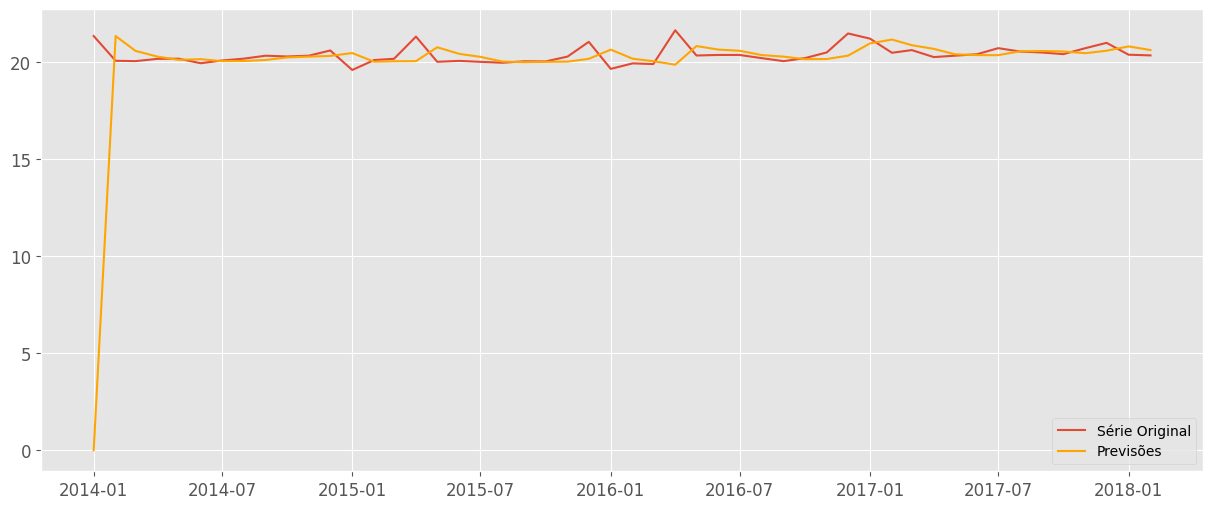

In [237]:
# Plot
figure(figsize = (15, 6))
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes_v3, color = 'orange', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

Verificar sigma2, quanto menor "melhor"

In [238]:
# Sumário do Modelo 
modelo_v3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     VALOR_EMPENHADO_log   No. Observations:                   50
Model:                  ARIMA(2, 1, 0)   Log Likelihood                 -37.706
Date:                 Mon, 23 Sep 2024   AIC                             81.413
Time:                         10:38:03   BIC                             87.088
Sample:                     01-01-2014   HQIC                            83.566
                          - 02-01-2018                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4707      0.150     -3.145      0.002      -0.764      -0.177
ar.L2         -0.1761      0.202     -0.872      0.383      -0.572       0.220
sigma2         0.2715      0.041      6.642      0.000       0.191       0.352
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                19.78
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.95
Prob(H) (two-sided):                  0.31   Kurtosis:                         5.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Aqui está uma interpretação dos resultados:

Modelo: ARIMA(2,1,0) indica que o modelo é um processo autorregressivo de segunda ordem (AR(2)) com uma diferenciação (I(1)) e sem parte de médias móveis (MA(0)).

Parâmetros AR:

- ar.L1: O coeficiente do primeiro termo autorregressivo é -0.3419, o que significa que há uma relação negativa entre o valor atual da série e o valor imediatamente anterior.
- ar.L2: O coeficiente do segundo termo autorregressivo é -0.0695, indicando uma relação negativa mais fraca com o segundo valor anterior.
- Variância do erro (sigma2): O valor de 0.1610 indica a variância dos erros do modelo. Quanto menor esse valor, melhor o ajuste do modelo aos dados.

Testes Estatísticos:

- Ljung-Box (Q): O teste Ljung-Box verifica a autocorrelação residual. Um valor de p (Prob(Q)) próximo de 1, como 0.95 aqui, sugere que não há evidências significativas de autocorrelação residual, indicando um bom ajuste do modelo.
- Jarque-Bera (JB): Este teste verifica a normalidade dos resíduos. Um valor de p (Prob(JB)) próximo de 0, como aqui, indica que os resíduos não são normalmente distribuídos. Isso pode ser uma preocupação e pode valer a pena investigar mais.
- Heteroskedasticity (H): Este teste verifica a homocedasticidade dos resíduos. Um valor de p (Prob(H)) próximo de 0 indica que há evidências de heterocedasticidade, o que significa que a variância dos resíduos não é constante ao longo do tempo.

Medidas de ajuste:

- AIC (Akaike Information Criterion): 16244.711. Um valor menor indica um melhor ajuste do modelo, mas é usado principalmente para comparar modelos.
- BIC (Bayesian Information Criterion): 16267.763. Assim como o AIC, um valor menor indica um melhor ajuste e é usado para comparações entre modelos.
- HQIC (Hannan-Quinn Information Criterion): 16252.334. Mais uma medida para comparar modelos, com um valor menor indicando um melhor ajuste.

O modelo ARIMA(2,1,0) parece se ajustar bem aos dados em termos de autocorrelação, mas há preocupações com a normalidade e a homocedasticidade dos resíduos. Isso pode afetar as previsões do modelo e a interpretação dos intervalos de confiança. Pode ser útil investigar transformações dos dados, adicionar variáveis exógenas ou considerar modelos alternativos para melhorar o ajuste.

In [239]:
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
df_previsoes_v3 = modelo_v3.forecast(len(df_valid['VALOR_EMPENHADO_log']), alpha = 0.05) 

In [240]:
df_previsoes_v3.shape

(78,)

In [241]:
df_previsoes_v3.head()

2018-03-01    20.488475
2018-04-01    20.436137
2018-05-01    20.438825
2018-06-01    20.446776
2018-07-01    20.442561
Freq: MS, Name: predicted_mean, dtype: float64

In [242]:
# Criamos a série para o gráfico
fc_series = pd.Series(df_previsoes_v3, index = df_valid.index)

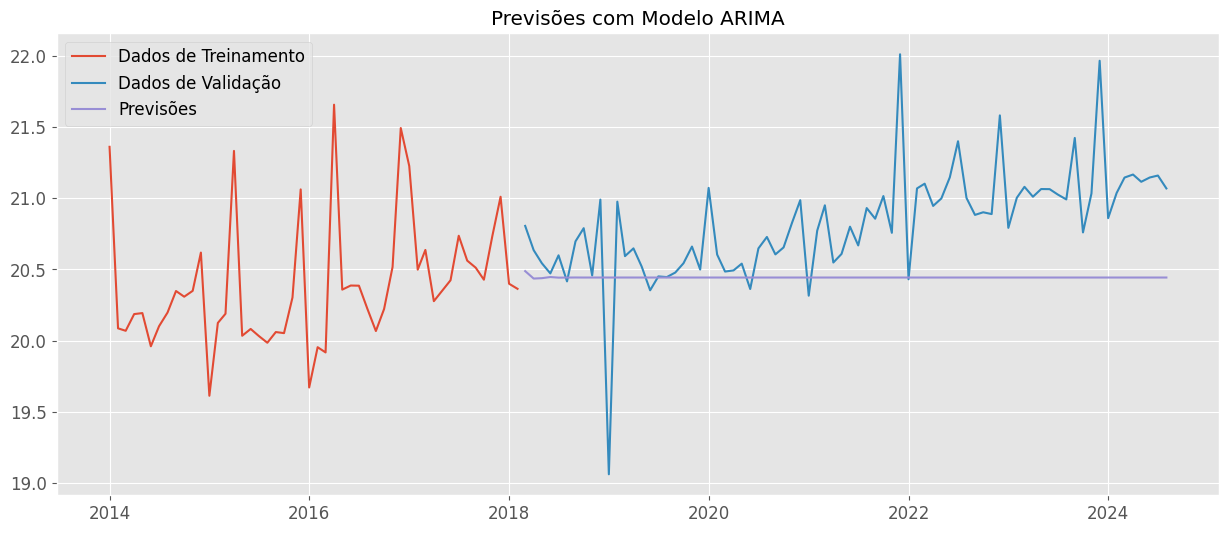

In [243]:
# Plot
figure(figsize = (15, 6))
plt.plot(df_treino['VALOR_EMPENHADO_log'], label = 'Dados de Treinamento')
plt.plot(df_valid['VALOR_EMPENHADO_log'], label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [244]:
# Replace de valores NaN por 0
fc_series = fc_series.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [245]:
df_valid.head()

,VALOR_EMPENHADO,VALOR_EMPENHADO_log,previsoes_v1,previsoes_v2
ANO_MES,,,,
2018-03-01,1.086823e+09,20.806524,20.556451,20.353622
2018-04-01,9.164570e+08,20.636026,20.556451,20.335952
2018-05-01,8.358283e+08,20.543934,20.556451,20.318282
2018-06-01,7.780134e+08,20.472254,20.556451,20.300613
2018-07-01,8.835981e+08,20.599513,20.556451,20.282943


In [246]:
# Define valor real e valor previsto
y_true = df_valid['VALOR_EMPENHADO_log']
y_pred = fc_series

In [247]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.5400693422718185


___

# Moledo - HW!

In [248]:
dados

,VALOR_EMPENHADO,VALOR_EMPENHADO_log
ANO_MES,,
2014-01-01,1.895801e+09,21.362907
2014-02-01,5.287013e+08,20.085934
2014-03-01,5.196278e+08,20.068623
2014-04-01,5.844282e+08,20.186145
2014-05-01,5.885324e+08,20.193142
...,...,...
2024-04-01,1.560008e+09,21.167956
2024-05-01,1.482428e+09,21.116947
2024-06-01,1.527629e+09,21.146983


Definindo freq

In [249]:
dados.freq = 'MS'

Definindo o valor de Alpha e definindo m (périodo de tempo)

In [250]:
m = 12
alpha = 1 / (2 * m)

<Axes: title={'center': 'Holt-Winters Exponential Smoothing'}, xlabel='ANO_MES'>

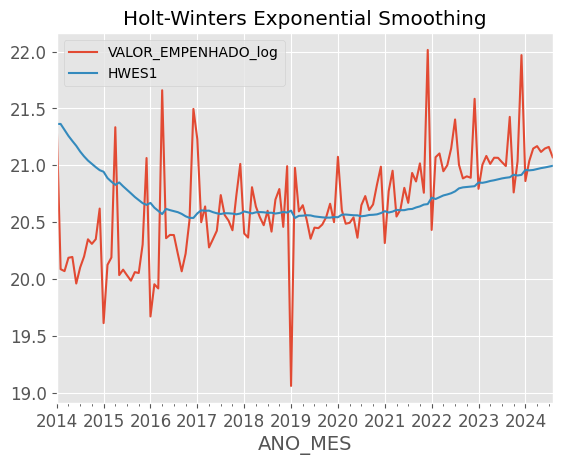

In [251]:
dados['HWES1'] = SimpleExpSmoothing(dados['VALOR_EMPENHADO_log']).fit(smoothing_level=alpha, optimized=False, use_brute=True).fittedvalues
dados[['VALOR_EMPENHADO_log', 'HWES1']].plot(title='Holt-Winters Exponential Smoothing')

HWES duplo
Então, ajustaríamos os dados no Double ES, tanto na tendência aditiva quanto na multiplicativa,


<Axes: title={'center': 'Holt-Winters Double Exponential Smoothing'}, xlabel='ANO_MES'>

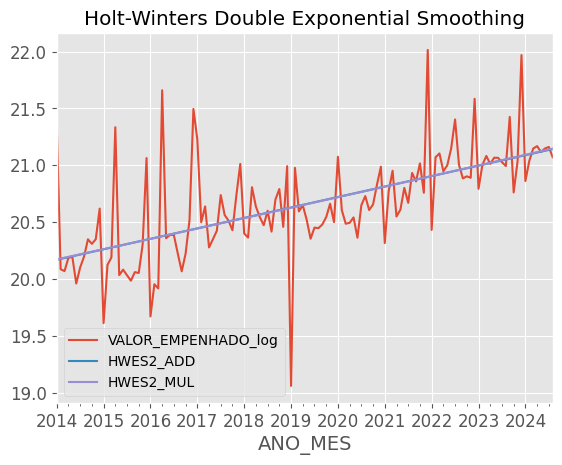

In [252]:

dados['HWES2_ADD'] = ExponentialSmoothing(dados['VALOR_EMPENHADO_log'], trend='add').fit().fittedvalues
dados['HWES2_MUL'] = ExponentialSmoothing(dados['VALOR_EMPENHADO_log'], trend='mul').fit().fittedvalues
dados[['VALOR_EMPENHADO_log', 'HWES2_ADD', 'HWES2_MUL']].plot(title='Holt-Winters Double Exponential Smoothing')

Triplo HWES3

<Axes: title={'center': 'Holt-Winters Triple Exponential Smoothing'}, xlabel='ANO_MES'>

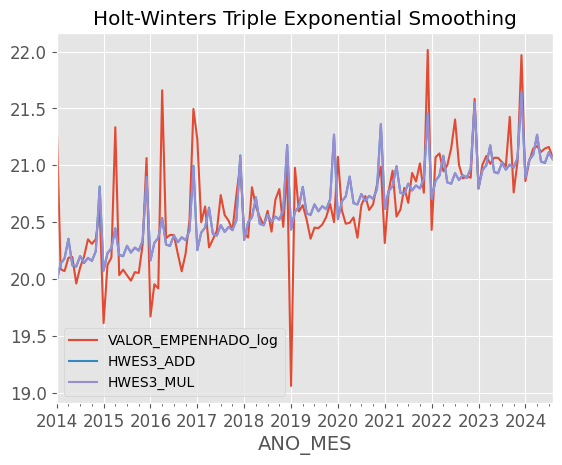

In [253]:
# Triplo HWES3_ADD
dados['HWES3_ADD'] = ExponentialSmoothing(dados['VALOR_EMPENHADO_log'], trend='add', seasonal='add', seasonal_periods=12).fit().fittedvalues
dados['HWES3_MUL'] = ExponentialSmoothing(dados['VALOR_EMPENHADO_log'], trend='mul', seasonal='mul', seasonal_periods=12).fit().fittedvalues
dados[['VALOR_EMPENHADO_log', 'HWES3_ADD', 'HWES3_MUL']].plot(title='Holt-Winters Triple Exponential Smoothing')

### Previsão

Text(0.5, 1.0, 'Treino, teste, previsão Holt Winters')

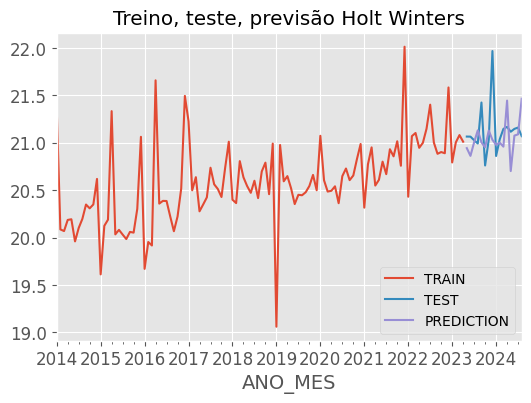

In [254]:
# Seprando treino e teste
train = dados.iloc[:len(dados)-16]
test = dados.iloc[len(dados)-16:]

# Ajustando o modelo
fitted_model = ExponentialSmoothing(train['VALOR_EMPENHADO_log'], trend='mul', seasonal='mul', seasonal_periods=16).fit()
test_predictions = fitted_model.forecast(16)

train['VALOR_EMPENHADO_log'].plot(legend=True, label='TRAIN', figsize=(6, 4))
test['VALOR_EMPENHADO_log'].plot(legend=True, label='TEST', figsize=(6, 4))
test_predictions.plot(legend=True, label='PREDICTION', figsize=(6, 4))

plt.title('Treino, teste, previsão Holt Winters')

In [255]:
np.exp(test_predictions)

2023-05-01    1.246781e+09
2023-06-01    1.149115e+09
2023-07-01    1.325605e+09
2023-08-01    1.504519e+09
2023-09-01    1.324917e+09
2023-10-01    1.258075e+09
2023-11-01    1.500970e+09
2023-12-01    1.360826e+09
2024-01-01    1.291578e+09
2024-02-01    1.320002e+09
2024-03-01    1.266377e+09
2024-04-01    2.058939e+09
2024-05-01    9.788301e+08
2024-06-01    1.423171e+09
2024-07-01    1.441960e+09
2024-08-01    2.099920e+09
Freq: MS, dtype: float64

In [256]:
test.head()

,VALOR_EMPENHADO,VALOR_EMPENHADO_log,HWES1,HWES2_ADD,HWES2_MUL,HWES3_ADD,HWES3_MUL
ANO_MES,,,,,,,
2023-05-01,1.408602e+09,21.065864,20.867763,21.027077,21.029090,20.940422,20.941436
2023-06-01,1.407576e+09,21.065135,20.876017,21.034742,21.036908,20.928634,20.930188
2023-07-01,1.354977e+09,21.027050,20.883897,21.042407,21.044729,21.020620,21.023480
2023-08-01,1.309425e+09,20.992854,20.889861,21.050073,21.052553,20.960801,20.962433
2023-09-01,2.017830e+09,21.425289,20.894153,21.057738,21.060379,21.004058,21.007134


In [257]:
# A valiação do modelo para cada modelo em coluna

for coluna in test.columns[2:]:
    print(f'{coluna}:')
    print('MAE:', mean_absolute_error(test[coluna], test_predictions))
    print('MSE:', mean_squared_error(test[coluna], test_predictions))
    print('RMSE:', np.sqrt(mean_squared_error(test[coluna], test_predictions)))
    print('MAPE:', mean_absolute_percentage_error(test[coluna], test_predictions))
    print('\n')



HWES1:
MAE: 0.15146266985346268
MSE: 0.04387662468469422
RMSE: 0.20946747882354966
MAPE: 0.007230828713261082


HWES2_ADD:
MAE: 0.1353016190980647
MSE: 0.031393567689030316
RMSE: 0.17718230072168697
MAPE: 0.006413120132577953


HWES2_MUL:
MAE: 0.13682246005334298
MSE: 0.03158163670193142
RMSE: 0.17771223002914407
MAPE: 0.006484165101658919


HWES3_ADD:
MAE: 0.1383792176588794
MSE: 0.046481897225677804
RMSE: 0.2155966076395401
MAPE: 0.006525698219796324


HWES3_MUL:
MAE: 0.14003399109587522
MSE: 0.047586259473998443
RMSE: 0.21814275022103863
MAPE: 0.006601376795197846




___

VALOR_EMPENHADO_log:
MAE: 0.2386113804900838
MSE: 0.13208280925629473
RMSE: 0.36343198711216207
MAPE: 0.013981399411988187


HWES1:
MAE: 0.29729132589338003
MSE: 0.1114764491220055
RMSE: 0.3338808906211997
MAPE: 0.017691949821757112


HWES2_ADD:
MAE: 0.2181913097863204
MSE: 0.09743322110245889
RMSE: 0.3121429497881682
MAPE: 0.012852227525841066


HWES2_MUL:
MAE: 0.2178338279070131
MSE: 0.09763792836972068
RMSE: 0.31247068401647005
MAPE: 0.012829856193876917


HWES3_ADD:
MAE: 0.2137103536056566
MSE: 0.11222844903650167
RMSE: 0.3350051477761225
MAPE: 0.01267724707501405


HWES3_MUL:
MAE: 0.21483123901133117
MSE: 0.11346336430017265
RMSE: 0.3368432340127565
MAPE: 0.01274611846712382




# SARIMAX
Otimização de hiperparâmetros  
Facilidade com sazionalidade

In [258]:
# Cria o modelo
modelo_SARIMAX = SARIMAX(df_treino['VALOR_EMPENHADO_log'], trend = 'n', order = (6,1,0), seasonal_order = (0,1,1,12))

In [259]:
# Treinamento do modelo
modelo_v4 = modelo_SARIMAX.fit(disp = True)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.74300D-01    |proj g|=  4.52425D-01

At iterate    1    f=  5.71762D-01    |proj g|=  3.73545D-01

At iterate    2    f=  5.54250D-01    |proj g|=  1.97584D-01

At iterate    3    f=  5.41571D-01    |proj g|=  2.39055D-01

At iterate    4    f=  5.28789D-01    |proj g|=  1.69448D-01

At iterate    5    f=  5.00180D-01    |proj g|=  2.31908D-01

At iterate    6    f=  4.73990D-01    |proj g|=  9.46129D-02

At iterate    7    f=  4.65995D-01    |proj g|=  8.61153D-02

At iterate    8    f=  4.58029D-01    |proj g|=  3.41626D-02

At iterate    9    f=  4.54303D-01    |proj g|=  3.43491D-02

At iterate   10    f=  4.50645D-01    |proj g|=  1.61622D-02

At iterate   11    f=  4.48226D-01    |proj g|=  2.62709D-02

At iterate   12    f=  4.47605D-01    |proj g|=  3.93129D-02

At iterate   13    f=  4.4

 This problem is unconstrained.


At iterate   31    f=  4.45741D-01    |proj g|=  7.80646D-04
  ys=-4.957E-06  -gs= 3.928E-06 BFGS update SKIPPED

At iterate   32    f=  4.45741D-01    |proj g|=  7.80747D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     32     58      1     1     0   7.807D-04   4.457D-01
  F =  0.44574098565940629     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [260]:
# Dados Reais e Previsões (em treino)
dados_reais = df_treino['VALOR_EMPENHADO_log']
previsoes_v4 = modelo_v4.fittedvalues

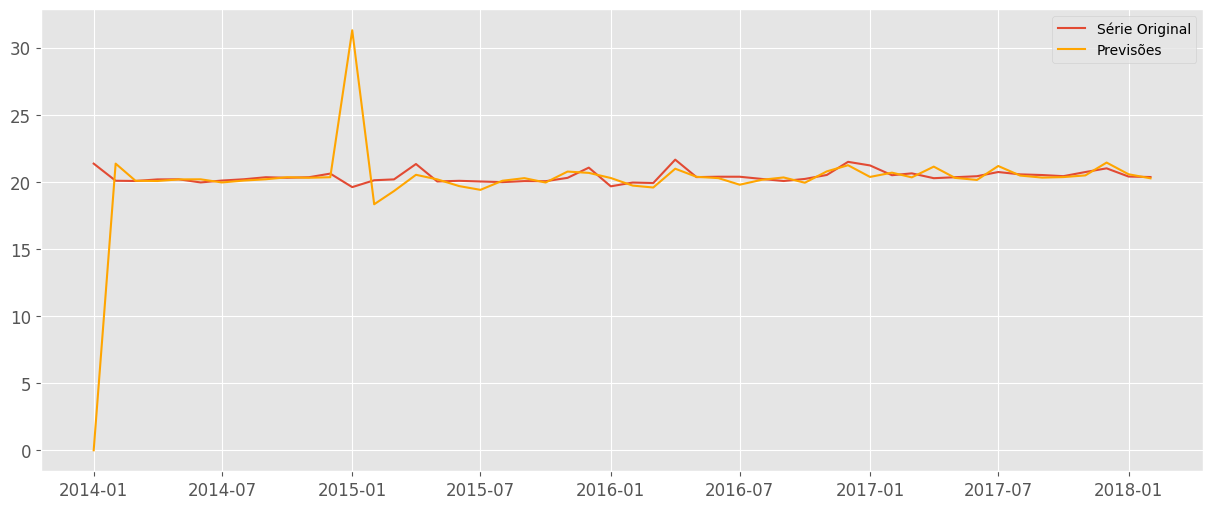

In [261]:
# Plot
figure(figsize = (15, 6))
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes_v4, color = 'orange', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

In [262]:
# Sumário do Modelo 
modelo_v4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                  VALOR_EMPENHADO_log   No. Observations:                   50
Model:             SARIMAX(6, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -22.287
Date:                              Mon, 23 Sep 2024   AIC                             60.574
Time:                                      10:38:04   BIC                             73.461
Sample:                                  01-01-2014   HQIC                            65.117
                                       - 02-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5489      0.263     -2.084      0.037      -1.065      -0.033
ar.L2         -0.2867      0.354     -0.810      0.418      -0.981       0.407
ar.L3         -0.8050      0.270     -2.984      0.003      -1.334      -0.276
ar.L4         -0.4819      0.351     -1.373      0.170      -1.170       0.206
ar.L5         -0.2651      0.324     -0.817      0.414      -0.901       0.371
ar.L6         -0.2652      0.255     -1.042      0.298      -0.764       0.234
ma.S.L12      -0.9956     44.667     -0.022      0.982     -88.542      86.551
sigma2         0.1168      5.229      0.022      0.982     -10.133      10.366
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.06
Prob(Q):                              0.78   Prob(JB):                         0.97
Heteroskedasticity (H):               0.56   Skew:                            -0.07
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Este modelo SARIMAX (Seasonal AutoRegressive Integrated Moving-Average with eXogenous variables) é um modelo de série temporal que inclui componentes sazonais. O modelo especificado é SARIMAX(6, 1, 0)x(0, 1, [1], 12), o que significa:

Parte não sazonal (ARIMA):

- AR(6): Processo autorregressivo de ordem 6.
- I(1): Diferenciação de primeira ordem.
- MA(0): Sem parte de médias móveis.

Parte sazonal:

- SAR(0): Sem componente autorregressivo sazonal.
- SI(1): Diferenciação sazonal de ordem 1.
- SMA(1): Média móvel sazonal de ordem 1.
- Período sazonal: 12 (indicando sazonalidade anual, presumivelmente mensal).

Aqui está uma interpretação dos resultados:

- Parâmetros AR: Os coeficientes dos termos autorregressivos (ar.L1 a ar.L6) mostram a relação entre o valor atual da série e seus valores anteriores. Por exemplo, o coeficiente ar.L1 é -0.4178, indicando uma relação negativa forte com o valor anterior.

- Parâmetro MA sazonal (ma.S.L12): O coeficiente de -0.9965 é muito próximo de -1, indicando uma forte relação negativa com o erro do termo sazonal anterior.

- Variância do erro (sigma2): O valor de 0.1464 indica a variância dos erros do modelo.

Testes Estatísticos:

- Ljung-Box (Q): Um valor de p (Prob(Q)) próximo de 1, como 0.99 aqui, sugere que não há evidências significativas de autocorrelação residual.
- Jarque-Bera (JB): Um valor de p (Prob(JB)) próximo de 0 indica que os resíduos não são normalmente distribuídos.
- Heteroskedasticity (H): Um valor de p (Prob(H)) próximo de 0 indica evidências de heterocedasticidade.

Medidas de ajuste:

- AIC (Akaike Information Criterion): 14776.188. Usado para comparar modelos, com um valor menor indicando um melhor ajuste.
- BIC (Bayesian Information Criterion): 14837.652. Semelhante ao AIC, um valor menor indica um melhor ajuste.
- HQIC (Hannan-Quinn Information Criterion): 14796.514. Outra medida para comparar modelos.

O modelo SARIMAX(6,1,0)x(0,1,[1],12) parece se ajustar bem aos dados em termos de autocorrelação, mas há preocupações com a normalidade e a homocedasticidade dos resíduos. A forte componente de média móvel sazonal indica uma relação significativa com os erros sazonais anteriores. Seria útil investigar a transformação dos dados ou a inclusão de variáveis exógenas para melhorar a normalidade dos resíduos e a homocedasticidade.

In [263]:
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
df_previsoes_v4 = modelo_v4.forecast(len(df_valid['VALOR_EMPENHADO_log']), alpha = 0.05) 

In [264]:
df_previsoes_v4.shape

(78,)

In [265]:
# Cria a série para o gráfico
fc_series = pd.Series(df_previsoes_v4, index = df_valid.index)

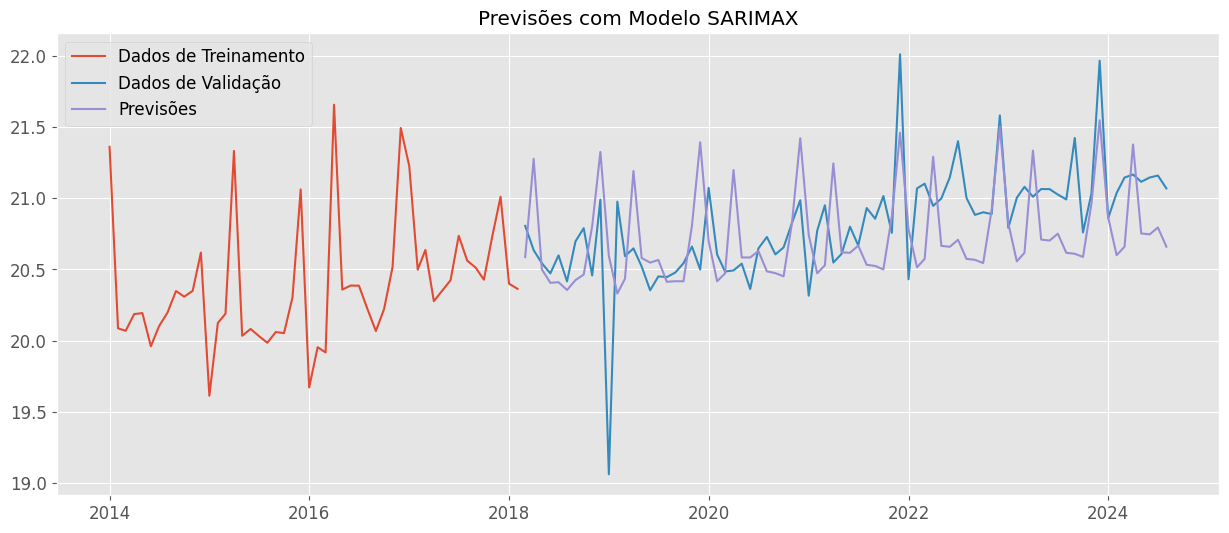

In [266]:
# Plot
figure(figsize = (15, 6))
plt.plot(df_treino['VALOR_EMPENHADO_log'], label = 'Dados de Treinamento')
plt.plot(df_valid['VALOR_EMPENHADO_log'], label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões')
plt.title('Previsões com Modelo SARIMAX')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [267]:
# Replace de valores NaN por 0
fc_series = fc_series.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [268]:
# Define valor real e valor previsto
y_true = df_valid['VALOR_EMPENHADO_log']
y_pred = fc_series

In [269]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.4049905044372894


___

### Previsões com a versão SARIMAX

Previsões para o melhor modelo ajustado

In [270]:
# Próximos 16 meses
dados_previsao_futura.head()

,VALOR_EMPENHADO,VALOR_EMPENHADO_log,data
2024-09-01,0.0,NaN,2024-09-01
2024-10-01,0.0,NaN,2024-10-01
2024-11-01,0.0,NaN,2024-11-01
2024-12-01,0.0,NaN,2024-12-01
2025-01-01,0.0,NaN,2025-01-01


In [271]:
dados_previsao_futura.shape

(200, 3)

In [272]:
# Vamos fazer a previsão para uma janela de 16 meses
previsoes = modelo_v4.predict(start = dados_previsao_futura.data[0], 
                              end = dados_previsao_futura.data[16], 
                              dynamic = False)

In [273]:
previsoes[1:30]

2024-10-01    20.631319
2024-11-01    21.006567
2024-12-01    21.592954
2025-01-01    20.911545
2025-02-01    20.643872
2025-03-01    20.703610
2025-04-01    21.422681
2025-05-01    20.796734
2025-06-01    20.790206
2025-07-01    20.838901
2025-08-01    20.703831
2025-09-01    20.697139
2025-10-01    20.674592
2025-11-01    21.049816
2025-12-01    21.636210
2026-01-01    20.954827
Freq: MS, Name: predicted_mean, dtype: float64

In [274]:
# Inversa da transformação de log
np.exp(previsoes[1:30])

2024-10-01    9.121536e+08
2024-11-01    1.327505e+09
2024-12-01    2.386166e+09
2025-01-01    1.207171e+09
2025-02-01    9.236759e+08
2025-03-01    9.805357e+08
2025-04-01    2.012575e+09
2025-05-01    1.076234e+09
2025-06-01    1.069231e+09
2025-07-01    1.122586e+09
2025-08-01    9.807524e+08
2025-09-01    9.742111e+08
2025-10-01    9.524916e+08
2025-11-01    1.386178e+09
2025-12-01    2.491647e+09
2026-01-01    1.260567e+09
Freq: MS, Name: predicted_mean, dtype: float64

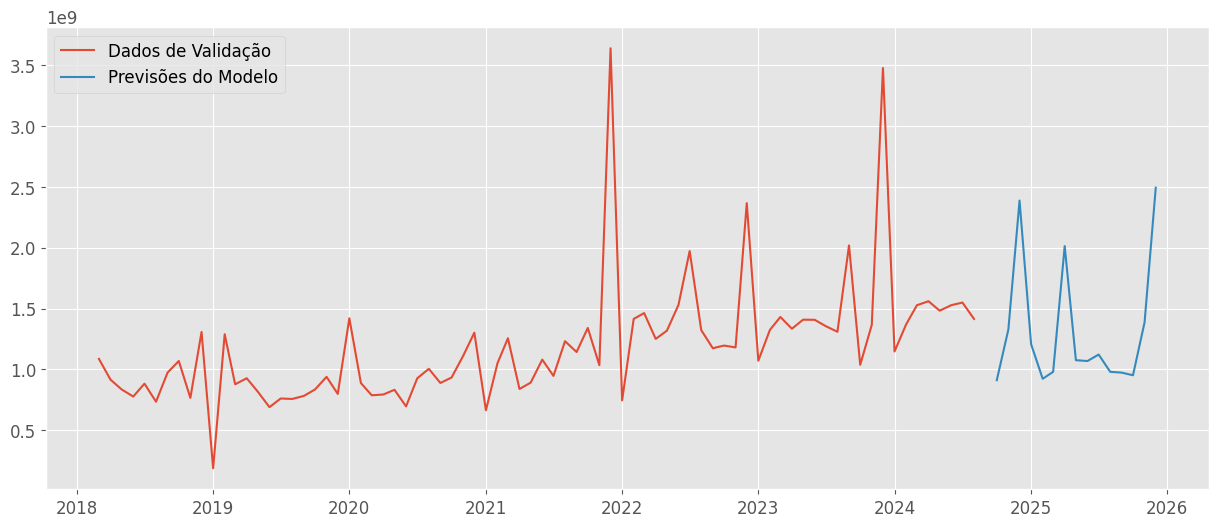

In [275]:
# Plot das Previsões
figure(figsize = (15, 6))
plt.plot(df_valid['VALOR_EMPENHADO'], label = 'Dados de Validação')
plt.plot(np.exp(previsoes[1:16]), label = 'Previsões do Modelo')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [276]:
# Buscar os últimos 24 meses dos dados de validação
df_valid_ultimos_24_meses = df_valid.tail(12)

In [277]:
df_valid_ultimos_24_meses.head()

,VALOR_EMPENHADO,VALOR_EMPENHADO_log,previsoes_v1,previsoes_v2
ANO_MES,,,,
2023-09-01,2.017830e+09,21.425289,20.556451,19.18741
2023-10-01,1.038205e+09,20.760759,20.556451,19.16974
2023-11-01,1.365538e+09,21.034814,20.556451,19.15207
2023-12-01,3.473475e+09,21.968421,20.556451,19.13440
2024-01-01,1.147500e+09,20.860852,20.556451,19.11673


In [278]:
df_valid_ultimos_24_meses.tail()

,VALOR_EMPENHADO,VALOR_EMPENHADO_log,previsoes_v1,previsoes_v2
ANO_MES,,,,
2024-04-01,1.560008e+09,21.167956,20.556451,19.063721
2024-05-01,1.482428e+09,21.116947,20.556451,19.046051
2024-06-01,1.527629e+09,21.146983,20.556451,19.028381
2024-07-01,1.549085e+09,21.160930,20.556451,19.010711
2024-08-01,1.414779e+09,21.070239,20.556451,18.993041


In [279]:
previsoes.head()

2024-09-01    20.653827
2024-10-01    20.631319
2024-11-01    21.006567
2024-12-01    21.592954
2025-01-01    20.911545
Freq: MS, Name: predicted_mean, dtype: float64

In [280]:
previsoes.shape

(17,)

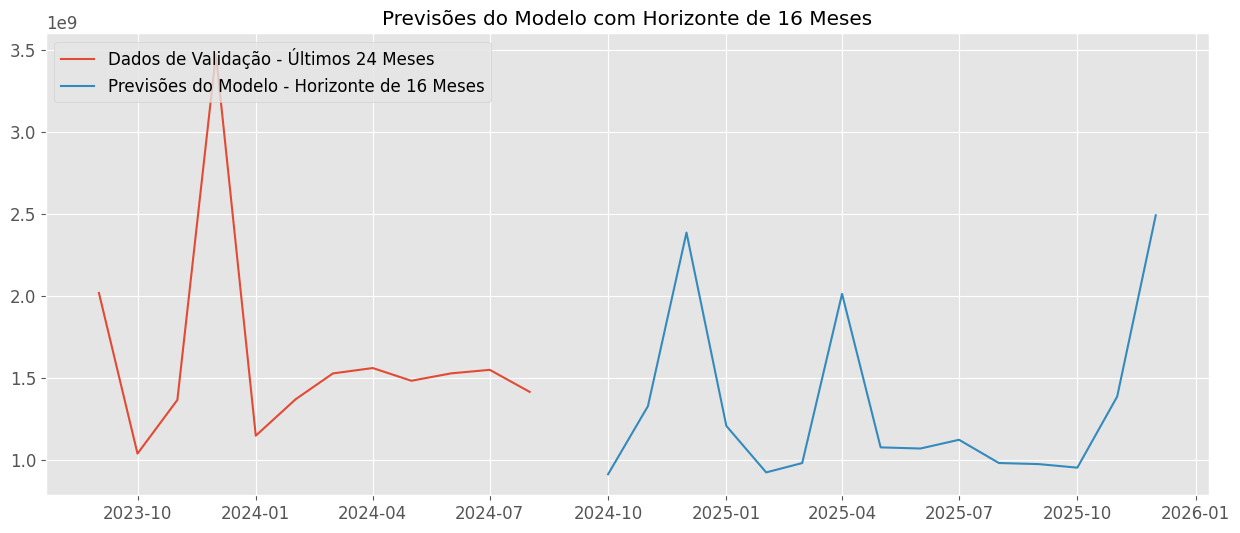

In [281]:
# Criamos uma nova série para as previsões com o índice correto
# O índice deve começar imediatamente após o último índice de df_valid_ultimas_120_horas
inicio_previsoes = df_valid_ultimos_24_meses.index[-1] + pd.Timedelta(hours = 1)
indice_previsoes = pd.date_range(start = inicio_previsoes, periods = len(previsoes[1:16]), freq = 'MS')
previsoes_series = pd.Series(np.exp(previsoes[1:16]))

# Plot das Previsões
figure(figsize = (15, 6))
plt.plot(df_valid_ultimos_24_meses['VALOR_EMPENHADO'], label = 'Dados de Validação - Últimos 24 Meses')
plt.plot(previsoes_series, label='Previsões do Modelo - Horizonte de 16 Meses')
plt.title('Previsões do Modelo com Horizonte de 16 Meses')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show();